# Setup

In [62]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import shap

import torch
import torch.nn as nn

from src.NNClassifiers.NNmodels import NNclassifier
from src.helpers import predict_model, prob_model

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Load data

In [29]:
#Data
feats_symptoms = ['sexo', 'edad', 'fiebre', 'tos', 'odinogia', 'disnea', 'irritabi',
        			'diarrea', 'dotoraci', 'calofrios', 'cefalea', 'mialgias', 'artral',
                    'ataedoge', 'rinorrea', 'polipnea', 'vomito', 'dolabdo', 'conjun',
                    'cianosis', 'inisubis']

feats_hosp = ['sexo',  'edad', 'fiebre', 'tos', 'odinogia', 'disnea',
                           'irritabi', 'diarrea', 'dotoraci', 'calofrios', 'cefalea', 'mialgias',
                           'artral', 'ataedoge', 'rinorrea', 'polipnea', 'vomito', 'dolabdo',
                           'conjun', 'cianosis', 'inisubis', 'diabetes', 'epoc', 'asma',
                           'inmusupr', 'hiperten', 'vih_sida', 'otracon', 'enfcardi', 'obesidad',
                           'insrencr', 'tabaquis']

feats_death= ['sexo', 'edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hiperten',
                            'vih_sida', 'otracon', 'enfcardi', 'obesidad', 'insrencr', 'tabaquis']

X_train_death = pd.read_csv('cnn-test-train-val-data\X_train_death.csv',names=feats_death)
Y_train_death = pd.read_csv('cnn-test-train-val-data\Y_train_death.csv',names=['target'])
X_train_diagnosis = pd.read_csv('cnn-test-train-val-data\X_train_diagnosis.csv',names=feats_symptoms)
Y_train_diagnosis = pd.read_csv('cnn-test-train-val-data\Y_train_diagnosis.csv',names=['target'])
X_train_hosp = pd.read_csv('cnn-test-train-val-data\X_train_hosp.csv',names=feats_hosp)
Y_train_hosp = pd.read_csv('cnn-test-train-val-data\Y_train_hosp.csv',names=['target'])

X_test_death = pd.read_csv('cnn-test-train-val-data\X_test_death.csv',names=feats_death)
Y_test_death = pd.read_csv('cnn-test-train-val-data\Y_test_death.csv',names=['target'])
X_test_diagnosis = pd.read_csv('cnn-test-train-val-data\X_test_diagnosis.csv',names=feats_symptoms)
Y_test_diagnosis = pd.read_csv('cnn-test-train-val-data\Y_test_diagnosis.csv',names=['target'])
X_test_hosp = pd.read_csv('cnn-test-train-val-data\X_test_hosp.csv',names=feats_hosp)
Y_test_hosp = pd.read_csv('cnn-test-train-val-data\Y_test_hosp.csv',names=['target'])

X_val_death = pd.read_csv('cnn-test-train-val-data\X_val_death.csv',names=feats_death)
Y_val_death = pd.read_csv("cnn-test-train-val-data\Y_val_death.csv",names=['target'])
X_val_diagnosis = pd.read_csv("cnn-test-train-val-data\X_val_diagnosis.csv",names=feats_symptoms)
Y_val_diagnosis = pd.read_csv("cnn-test-train-val-data\Y_val_diagnosis.csv",names=['target'])
X_val_hosp = pd.read_csv("cnn-test-train-val-data\X_val_hosp.csv",names=feats_hosp)
Y_val_hosp = pd.read_csv("cnn-test-train-val-data\Y_val_hosp.csv",names=['target'])

# Concat both ds to have 1 ds for peformance metrics and variable explanations
X_death = pd.concat([X_test_death,X_val_death])
Y_death = pd.concat([Y_test_death,Y_val_death])
X_diagnosis = pd.concat([X_test_diagnosis,X_val_diagnosis])
Y_diagnosis = pd.concat([Y_test_diagnosis,Y_val_diagnosis])
X_hosp = pd.concat([X_test_hosp,X_val_hosp])
Y_hosp = pd.concat([Y_test_hosp,Y_val_hosp])

In [3]:
#Models
device = "cuda" if torch.cuda.is_available() else "cpu"
model_death = torch.load('torch_models\model_death.pth', map_location=torch.device(device))
model_diagnosis = torch.load('torch_models\model_diagnosis.pth', map_location=torch.device(device))
model_hosp = torch.load('torch_models\model_hosp.pth', map_location=torch.device(device))

# Get predicted values 

In [20]:
Y_pred_death_tensor = model_death(torch.tensor(X_death.to_numpy())[:,None, :].to(device).float())
Y_pred_death_prob = np.exp(Y_pred_death_tensor.cpu().detach().numpy())[:,1]
np.savetxt('cnn-test-train-val-data\Y_pred_death_prob.csv',Y_pred_death_prob,delimiter=',')

In [21]:
Y_pred_diagnosis_tensor = model_diagnosis(torch.tensor(X_diagnosis.to_numpy())[:,None, :].to(device).float())
Y_pred_diagnosis_prob = np.exp(Y_pred_diagnosis_tensor.cpu().detach().numpy())[:,1]
np.savetxt('cnn-test-train-val-data\Y_pred_diagnosis_prob.csv',Y_pred_diagnosis_prob,delimiter=',')

In [5]:
Y_pred_hosp_tensor = model_hosp(torch.tensor(X_hosp.to_numpy())[:,None, :].to(device).float())
Y_pred_hosp_prob = np.exp(Y_pred_hosp_tensor.cpu().detach().numpy())[:,1]
np.savetxt('cnn-test-train-val-data\Y_pred_hosp_prob.csv',Y_pred_hosp_prob,delimiter=',')

# Peformance

In [4]:
Y_pred_death_prob = np.genfromtxt('cnn-test-train-val-data\Y_pred_death_prob.csv',delimiter=',') 
Y_pred_diagnosis_prob = np.genfromtxt('cnn-test-train-val-data\Y_pred_diagnosis_prob.csv',delimiter=',') 
Y_pred_hosp_prob = np.genfromtxt('cnn-test-train-val-data\Y_pred_hosp_prob.csv',delimiter=',') 

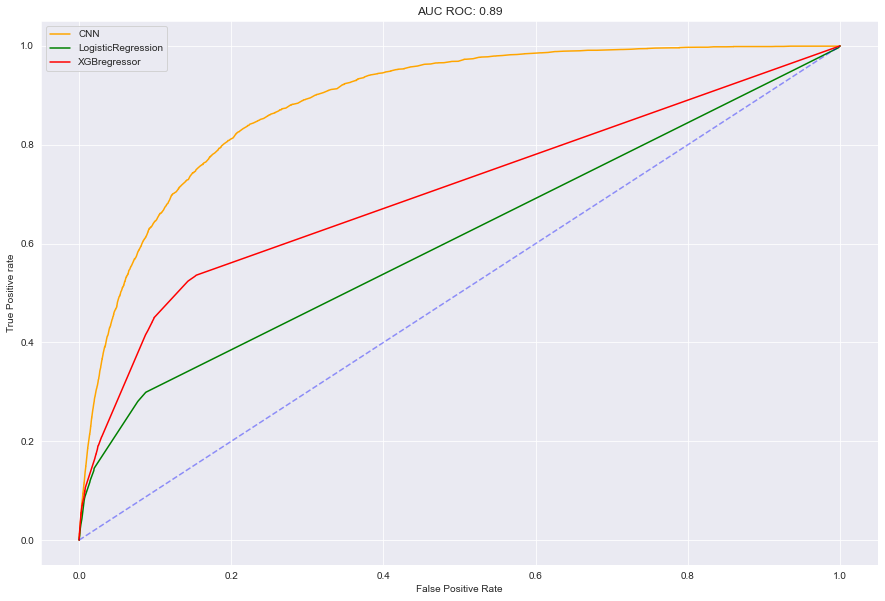

In [69]:
#Logistic regression model
clf = LogisticRegression(random_state=0).fit(X_train_death.to_numpy(), Y_train_death.to_numpy().reshape(-1,))
#XGB classifier
xgbc=XGBClassifier(max_depth=5,colsample_bytree=0.8,learning_rate=0.02,n_estimators=100,nthread=-1,eval_metric="logloss")
xgbc.fit(X_train_death.to_numpy(),(Y_train_death.to_numpy().reshape(-1,)))

fpr1, tpr1, _ = roc_curve(Y_death, Y_pred_death_prob, pos_label=1)
auc = roc_auc_score(Y_death, Y_pred_death_prob)

fpr2, tpr2, _ = roc_curve(Y_death, clf.predict_proba(X_death.to_numpy())[:,1], pos_label=1)
fpr3, tpr3, _ = roc_curve(Y_death, xgbc.predict_proba(X_death.to_numpy())[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(Y_death))]
p_fpr, p_tpr, _ = roc_curve(Y_death, random_probs, pos_label=1)

plt.figure(figsize=(15,10))
plt.plot(fpr1, tpr1,color='orange', label='CNN')
plt.plot(fpr2, tpr2,color='green', label='LogisticRegression')
plt.plot(fpr3, tpr3,color='red', label='XGBregressor')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue',alpha=0.4)
plt.title(f"AUC ROC: {np.round(auc,2)}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

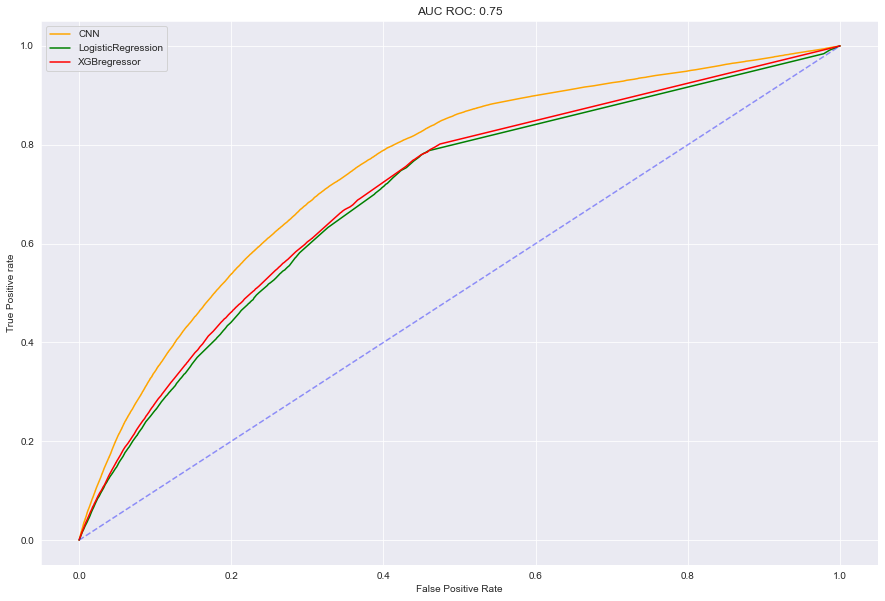

In [70]:
#Logistic regression model
clf = LogisticRegression(random_state=0).fit(X_train_diagnosis.to_numpy(), Y_train_diagnosis.to_numpy().reshape(-1,))
#XGB classifier
xgbc=XGBClassifier(max_depth=5,colsample_bytree=0.8,learning_rate=0.02,n_estimators=100,nthread=-1,eval_metric="logloss")
xgbc.fit(X_train_diagnosis.to_numpy(),(Y_train_diagnosis.to_numpy().reshape(-1,)))

fpr1, tpr1, _ = roc_curve(Y_diagnosis, Y_pred_diagnosis_prob, pos_label=1)
auc = roc_auc_score(Y_diagnosis, Y_pred_diagnosis_prob)

fpr2, tpr2, _ = roc_curve(Y_diagnosis, clf.predict_proba(X_diagnosis.to_numpy())[:,1], pos_label=1)
fpr3, tpr3, _ = roc_curve(Y_diagnosis, xgbc.predict_proba(X_diagnosis.to_numpy())[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(Y_diagnosis))]
p_fpr, p_tpr, _ = roc_curve(Y_diagnosis, random_probs, pos_label=1)

plt.figure(figsize=(15,10))
plt.plot(fpr1, tpr1,color='orange', label='CNN')
plt.plot(fpr2, tpr2,color='green', label='LogisticRegression')
plt.plot(fpr3, tpr3,color='red', label='XGBregressor')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue',alpha=0.4)
plt.title(f"AUC ROC: {np.round(auc,2)}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

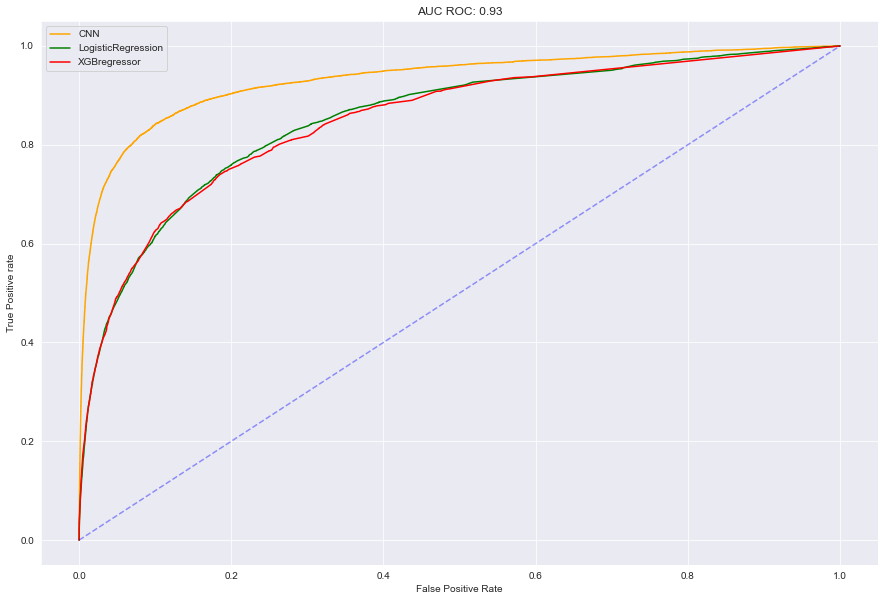

In [76]:
#Logistic regression model
clf = LogisticRegression(random_state=0).fit(X_train_hosp.to_numpy(), Y_train_hosp.to_numpy().reshape(-1,))
#XGB classifier
xgbc=XGBClassifier(max_depth=5,colsample_bytree=0.8,learning_rate=0.02,n_estimators=100,nthread=-1,eval_metric="logloss")
xgbc.fit(X_train_hosp.to_numpy(),(Y_train_hosp.to_numpy().reshape(-1,)))

fpr1, tpr1, _ = roc_curve(Y_hosp, Y_pred_hosp_prob, pos_label=1)
auc = roc_auc_score(Y_hosp, Y_pred_hosp_prob)

fpr2, tpr2, _ = roc_curve(Y_hosp, clf.predict_proba(X_hosp.to_numpy())[:,1], pos_label=1)
fpr3, tpr3, _ = roc_curve(Y_hosp, xgbc.predict_proba(X_hosp.to_numpy())[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(Y_hosp))]
p_fpr, p_tpr, _ = roc_curve(Y_hosp, random_probs, pos_label=1)

plt.figure(figsize=(15,10))
plt.plot(fpr1, tpr1,color='orange', label='CNN')
plt.plot(fpr2, tpr2,color='green', label='LogisticRegression')
plt.plot(fpr3, tpr3,color='red', label='XGBregressor')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue',alpha=0.4)
plt.title(f"AUC ROC: {np.round(auc,2)}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()